Record len: 81
Record len: 81
Record len: 81
Record len: 80


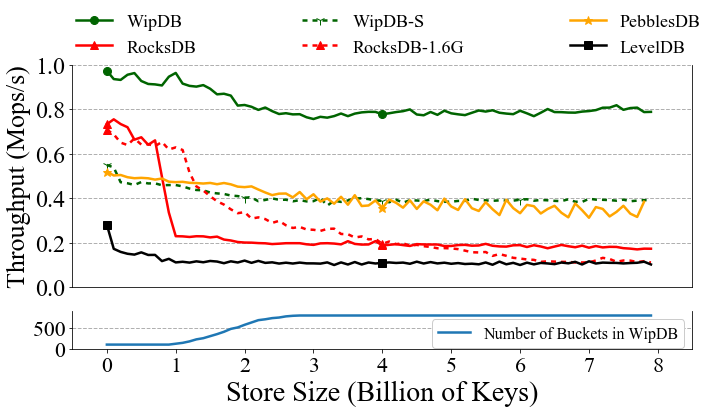

In [12]:
# libraries
import numpy as np
import pandas as pd
import os
import re
import seaborn as sns
from operator import truediv
from matplotlib.pyplot import figure
from matplotlib import gridspec
from matplotlib.ticker import FuncFormatter
from scipy.interpolate import interp1d
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'
rcParams['font.weight'] = 100
import matplotlib.pyplot as plt
%matplotlib inline

wip_wa = []
level_wa = []
peb_wa = []
rocks_wa = []

def ExtractWA(file, wa, dbtype='LevelWA'):
    res = pd.DataFrame(columns=['Level', 'Tables', 'Size(MB)', 'Time(sec)', 'Read(MB)', 'Write(MB)'])
    # Open the file with read only permit
    f = open(file)
    # use readline() to read the first line
    line = f.readline()
    # use the read line to read further.
    # If the file is not empty keep reading one line
    # at a time, till the file is empty

    io = 0
    while line:
        if line.startswith("-----------------"):
            line = f.readline()
            data = line.split()  # split string into a list
            io = io + int(data[5])
            while not line.startswith("20"):
                data = line.split()  # split string into a list
                if len(data) == 6:
                    for i in range(0, len(data)):
                        data[i] = int(data[i])
                    res.loc[len(res.index), :] = data
                else:
                    break
                line = f.readline()
                
            real_io = res.sum()[5]
            wa.append(real_io / io)
#             print(dbtype, real_io / io)
        line = f.readline()
    print("Record len:", len(wa))


def ExtractRocksWA(file):
    f = open(file)
    line = f.readline()
    wa = 0
    while line:
        if line.startswith(" Sum"): 
            data = line.split() #split string into a list
            wa = float(data[11])
#             print("RocksWA", wa)
            rocks_wa.append(wa)
        line = f.readline()
    print("Record len:", len(rocks_wa))
    return wa

def ExtractWipWA(file, res):
    f = open(file)
    line = f.readline()
    wa = 0
    while line:
        if line.startswith("WriteAm"): 
            data = line.split() #split string into a list
            wa = float(data[1])
#             print("WipWA", wa)
            res.append(wa)
        line = f.readline()
    print("Record len:", len(res))
    return wa


# # ================= plot wa bar ========================
# ax2.yaxis.tick_right()
# ax2.set_ylabel('Write Amplification', fontsize=24, color='k')
# ax2.yaxis.set_label_position("left")


ExtractWA('peb8B_nvm.log', peb_wa, "PebblesWA");
ExtractWipWA('level8B_nvm.log', level_wa);
ExtractRocksWA('rocks8B_nvm.log');
ExtractWipWA('kv8B_nvm_hugepage.log', wip_wa)

fig = plt.figure(figsize=(10, 6)) 
gs = gridspec.GridSpec(5, 4) 
ax1 = plt.subplot(gs[:-1, :])
ax1t = plt.subplot(gs[-1, :])




def extract_current(speeds):
    result = re.findall(r"[-+]?\d*\.\d+|\d+", speeds)
    return float(result[0])

def extract_avg(speeds):
    result = re.findall(r"[-+]?\d*\.\d+|\d+", speeds)
    return float(result[1])

wip   = pd.DataFrame(columns = ['time', 'thread', 'count', 'speed']) 
wip_skiplist   = pd.DataFrame(columns = ['time', 'thread', 'count', 'speed']) 
rocks   = pd.DataFrame(columns = ['time', 'thread', 'count', 'speed']) 
rocks1G = pd.DataFrame(columns = ['time', 'thread', 'count', 'speed']) 
level   = pd.DataFrame(columns = ['time', 'thread', 'count', 'speed']) 
peb     = pd.DataFrame(columns = ['time', 'thread', 'count', 'speed'])

wip_bucket = pd.DataFrame(columns = ['Number of Buckets in WipDB']) 
wip_skiplist_bucket = pd.DataFrame(columns = ['Number fo Buckets']) 

with open("rocks8B_nvm_1GBMem.log") as origin_file:
    for line in origin_file:
        if line.startswith("20"):
            data = line.strip().split()
            data = [data[i] for i in (0,3,4,7)]
            rocks1G.loc[len(rocks1G)] = data
        
with open("rocks8B_nvm.log") as origin_file:
    for line in origin_file:
        if line.startswith("2019/0"):
            data = line.strip().split()
            data = [data[i] for i in (0,3,4,7)]
            rocks.loc[len(rocks)] = data

with open("level8B_nvm.log") as origin_file:
    for line in origin_file:
        if line.startswith("2019/0"):
            data = line.strip().split()
            data = [data[i] for i in (0,3,4,7)]
            level.loc[len(level)] = data
            
with open("peb8B_nvm.log") as origin_file:
    for line in origin_file:
        if line.startswith("20"):
            data = line.strip().split()
            data = [data[i] for i in (0,3,4,7)]
            peb.loc[len(peb)] = data
            
with open("kv8B_nvm_hugepage.log") as origin_file:
    for line in origin_file:
        if line.startswith("2019/0"):
            data = line.strip().split()
            data = [data[i] for i in (0,3,4,7)]
            wip.loc[len(wip)] = data
        if line.startswith("Bucket"):
            data = line.strip().split();
            wip_bucket.loc[len(wip_bucket)] = float(data[1])


with open("kv8B_nvm_skip_hugepage.log") as origin_file:
    for line in origin_file:
        if line.startswith("2019/0"):
            data = line.strip().split()
            data = [data[i] for i in (0,3,4,7)]
            wip_skiplist.loc[len(wip_skiplist)] = data
        if line.startswith("Bucket"):
            data = line.strip().split();
            wip_skiplist_bucket.loc[len(wip_skiplist_bucket)] = float(data[1])



df = pd.DataFrame(columns = []) 
df['wip_cur']   = wip['speed'].apply(extract_current)
df['wip_cur_skiplist']   = wip_skiplist['speed'].apply(extract_current)
df['peb_cur']   = peb['speed'].apply(extract_current)
df['rocks_cur'] = rocks['speed'].apply(extract_current)
df['level_cur'] = level['speed'].apply(extract_current)
df['rocks1G_cur'] = rocks1G['speed'].apply(extract_current)
df = df / 1000.0 / 1000.0
# df = df.rolling(4).mean()



# ================= plot speed ========================
# Ensure that the axis ticks only show up on the bottom and left of the plot.
# Ticks on the right and top of the plot are generally unnecessary.
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()
ax1.set_xticks(range(0, 500, 10))



def billions(x, pos):
    'The two args are the value and tick position'
    return '%1.f' % (x/10)
formatter = FuncFormatter(billions)
ax1.xaxis.set_major_formatter(formatter)
ax1.spines["top"].set_visible(False) 


# df.plot(ax=ax1)
lw=2.5
df['wip_cur'].plot(ax=ax1, fontsize=24, color='darkgreen', marker='o', markevery=40, markersize=8, linewidth=lw)
df['rocks_cur'].plot(ax=ax1, fontsize=24, color='red', marker='^', markevery=40, markersize=8, linewidth=lw)
df['wip_cur_skiplist'].plot(ax=ax1, fontsize=24, color='darkgreen', dashes=[2, 2], marker='1', markevery=20, markersize=10, linewidth=lw)
(df['rocks1G_cur']*1.6).plot(ax=ax1, fontsize=24, color='red', marker='^', dashes=[2, 2], markevery=40, markersize=8, linewidth=lw)
df['peb_cur'].plot(ax=ax1, fontsize=24, color='orange', marker='*', markevery=40, markersize=9, linewidth=lw)
df['level_cur'].plot(ax=ax1, fontsize=24, color='k', marker='s', markevery=40, markersize=8, linewidth=lw)
ax1.yaxis.grid(linewidth=1, linestyle='--')
ax1.set_axisbelow(True)
ax1.set_xlim(-5, 85)
ax1.set_ylim(0, 1)
ax1.legend(["WipDB", "RocksDB", "WipDB-S", "RocksDB-1.6G", "PebblesDB", "LevelDB"], loc="upper right", 
           fontsize=18, edgecolor='k',facecolor='k', framealpha=0, mode="expand", ncol=3,  bbox_to_anchor=(-0.02, 1.2, 1.06, .102))
ax1.set_ylabel('Throughput (Mops/s)', fontsize=26, color='k')
ax1.set_xticks([])



WA = pd.DataFrame(columns = []) 
WA['wip'] = wip_wa
WA.loc[:,'peb'] = pd.Series(peb_wa)
WA.loc[:,'rocks'] = pd.Series(rocks_wa)
WA.loc[:,'level'] = pd.Series(level_wa)

wip_bucket.plot(ax=ax1t, fontsize=22, linewidth=lw)
ax1t.yaxis.grid(linewidth=1, linestyle='--')
ax1t.xaxis.grid(False)
ax1t.spines["top"].set_visible(False) 
ax1t.set_xlim(-5, 85)
ax1t.set_ylim(0, 900)
ax1t.set_xlabel('Store Size (Billion of Keys)', fontsize=28, color='k')
def billions(x, pos):
    'The two args are the value and tick position'
    return '%1.f' % (x/10)
formatter = FuncFormatter(billions)
ax1t.xaxis.set_major_formatter(formatter)
plt.legend(prop={'size': 16}, fancybox=True, framealpha=1)

fig.tight_layout()
plt.savefig("8BInsert_cur.pdf", bbox_inches='tight')

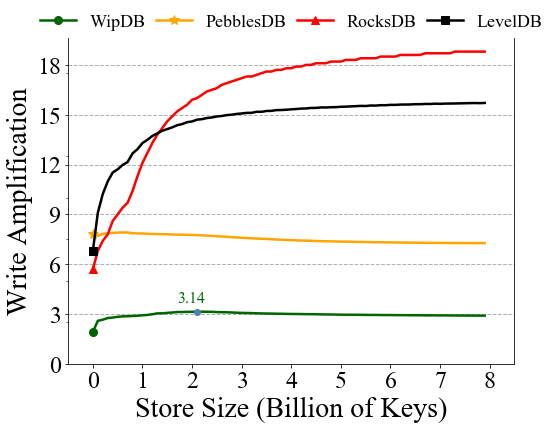

In [13]:
# libraries
import numpy as np
import pandas as pd
import os
import re
from operator import truediv
from matplotlib.pyplot import figure
from matplotlib import gridspec
from matplotlib.ticker import FuncFormatter
from scipy.interpolate import interp1d


from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'
rcParams['font.weight'] = 100
import matplotlib.pyplot as plt

%matplotlib inline

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(5, 4) 
ax1 = plt.subplot(gs[:, :])
# ax1t = plt.subplot(gs[-1, :])

df = pd.DataFrame(columns = []) 
df['wip'] = wip_wa
df.loc[:,'peb'] = pd.Series(peb_wa)
df.loc[:,'rocks'] = pd.Series(rocks_wa)
df.loc[:,'level'] = pd.Series(level_wa)

# # ================= plot speed ========================
# # Ensure that the axis ticks only show up on the bottom and left of the plot.
# # Ticks on the right and top of the plot are generally unnecessary.
# ax1.get_xaxis().tick_bottom()
# ax1.get_yaxis().tick_left()
# ax1.set_xticks(range(0, 500, 10))

def billions(x, pos):
    'The two args are the value and tick position'
    return '%1.f' % (x/10)
formatter = FuncFormatter(billions)
ax1.xaxis.set_major_formatter(formatter)
ax1.spines["top"].set_visible(False) 

df['wip'].plot(ax=ax1, fontsize=24, color='darkgreen', marker='o', markevery=100, markersize=8, linewidth=lw)
df['peb'].plot(ax=ax1, fontsize=24, color='orange', marker='*', markevery=100, markersize=10, linewidth=lw)
df['rocks'].plot(ax=ax1, fontsize=24, color='red', marker='^', markevery=100, markersize=8, linewidth=lw)
df['level'].plot(ax=ax1, fontsize=24, color='k', marker='s', markevery=100, markersize=8, linewidth=lw)

ax1.yaxis.grid(linewidth=1, linestyle='--')
ax1.set_axisbelow(True)
ax1.set_xlim(-5, 85)

wa_pos=21
ax1.plot([wa_pos], [df['wip'][wa_pos]], color='steelblue', marker='o')
ax1.text(wa_pos - 4, 3.7, "%.2f" % (df['wip'][wa_pos],), color='darkgreen', fontsize=16)

ax1.legend(["WipDB", "PebblesDB", "RocksDB", "LevelDB"], loc="upper right", fontsize=18, 
          edgecolor='k',facecolor='k', framealpha=0, mode="expand", ncol=4,  bbox_to_anchor=(-0.1, 1.02, 1.2, .102))

ax1.set_ylabel('Write Amplification', fontsize=28, color='k')

major_ticks = np.arange(0, 20, 3)
minor_ticks = np.arange(0, 20, 2.5)
ax1.set_yticks(major_ticks)
ax1.set_yticks(minor_ticks, minor=True)
ax1.set_xlim(-5, 85)
ax1.set_xlabel('Store Size (Billion of Keys)', fontsize=28, color='k')
def billions(x, pos):
    'The two args are the value and tick position'
    return '%1.f' % (x/10)
formatter = FuncFormatter(billions)
ax1.xaxis.set_major_formatter(formatter)

# wip_bucket.plot(ax=ax1t, fontsize=22)
# ax1t.yaxis.grid(linewidth=1, linestyle='--')
# ax1t.xaxis.grid(False)
# ax1t.set_xlim(-5, 85)
# ax1t.set_xlabel('Store Size (Billion of Keys)', fontsize=28, color='k')
# def billions(x, pos):
#     'The two args are the value and tick position'
#     return '%1.f' % (x/10)
# formatter = FuncFormatter(billions)
# ax1t.xaxis.set_major_formatter(formatter)
# ax1t.spines["top"].set_visible(False) 
# plt.legend(prop={'size': 20}, fancybox=True, framealpha=0.5)
# fig.tight_layout()

plt.savefig("8BInsert_wa.pdf", bbox_inches='tight')

NameError: name 'font' is not defined

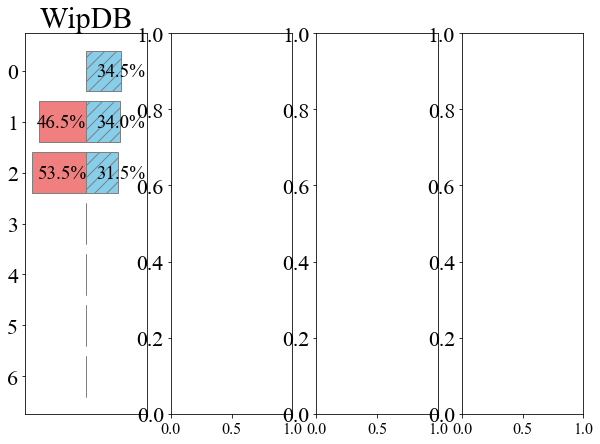

In [3]:
rcParams['xtick.labelsize']=16
rcParams['ytick.labelsize']=22
fig = plt.figure(figsize=(10, 7)) 
gs = gridspec.GridSpec(1, 4) 
ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])
ax2 = plt.subplot(gs[0, 2])
ax3 = plt.subplot(gs[0, 3])

wip_pyramid = pd.read_csv("io/kv.txt", delim_whitespace=True)
wip_pyramid.columns=["level", "time", "read", "write"]
wip_read_sum = wip_pyramid['read'].sum()
wip_pyramid['read'] = wip_pyramid['read'] / wip_read_sum * 100.0
wip_write_sum = wip_pyramid['write'].sum() 
wip_pyramid['write'] = wip_pyramid['write'] / wip_write_sum * 100.0
# print(wip_pyramid)

peb_pyramid = pd.read_csv("io/peb.txt", delim_whitespace=True)
peb_pyramid.columns=["level", "file", "size", "time", "read", "write"]
peb_read_sum = peb_pyramid['read'].sum()
peb_pyramid['read'] = peb_pyramid['read'] / peb_read_sum * 100.0
peb_write_sum = peb_pyramid['write'].sum()
peb_pyramid['write'] = peb_pyramid['write'] / peb_write_sum * 100.0
# print(peb_pyramid)

rocks_pyramid = pd.read_csv('io/rocks.txt', delim_whitespace=True)
rocks_pyramid = rocks_pyramid[["Level", "Read(GB)", "Write(GB)"]]
rocks_pyramid.columns=["level", "read", "write"]
rocks_read_sum = rocks_pyramid['read'].sum()
rocks_pyramid['read'] = rocks_pyramid['read'] / rocks_read_sum * 100.0
rocks_write_sum = rocks_pyramid['write'].sum()
rocks_pyramid['write'] = rocks_pyramid['write'] / rocks_write_sum * 100.0
# print(rocks_pyramid)

level_pyramid = pd.read_csv('io/level.txt', delim_whitespace=True)
level_pyramid.columns=["level", "file", "size", "time", "read", "write"]
level_read_sum = level_pyramid['read'].sum()
level_pyramid['read'] = level_pyramid['read'] / level_read_sum * 100.0
level_write_sum = level_pyramid['write'].sum()
level_pyramid['write'] = level_pyramid['write'] / level_write_sum * 100.0
# print(level_pyramid)

# font = {'family': 'consolas',
#         'weight': 'bold',
#         'size': 16,
#         }

def Pyrimaid(ax, df, m_title, total_write, total_read, is_ytick=False):
    write = df['write'].values.tolist()
    read  = df['read'].values.tolist()
    read  = [-x for x in read]
    while(len(write) != 7):
        write.append(0)
        read.append(0)
    X = np.arange(len(df)).tolist()
    while (len(X) != 7):
        X.append(len(X))    
    ax.barh(X, read,  color = 'lightcoral' , edgecolor='grey')
    ax.barh(X, write, color = 'skyblue', edgecolor='grey', hatch="//")
    ax.invert_yaxis()
    ax.set_title(m_title, fontsize=30)
    
    for i in range(7):
        if (write[i] != 0):
            ax.text(s='%04.1f' % (write[i],) + "%", y=X[i], x=10, color="k",
                 verticalalignment="center", horizontalalignment="left", size=19)
        if (read[i] != 0):
            ax.text(s='%04.1f' % (-read[i],) + "%", y=X[i],  x=0, color="k",
                 verticalalignment="center", horizontalalignment="right", size=19)
    ax.set_xlim([-60, 60])
    ax.set_xticks([])
    ax.set_xlabel(' R%04d GB \nW%04d GB' % (total_read / 1024, total_write / 1024,), fontsize=18, fontdict=font)
    if not is_ytick:
        ax.set_yticks([])
    else:
        ax.text(-94, -0.6, "Level", fontsize=16)
        ax.legend(["Read", "Write"], loc="lower center", fontsize=18, edgecolor='k')
    
Pyrimaid(ax0, wip_pyramid, "WipDB", wip_write_sum , wip_read_sum, True)
Pyrimaid(ax1, peb_pyramid, "PebbelsDB", peb_write_sum, peb_read_sum)
Pyrimaid(ax2, rocks_pyramid, "RocksDB", rocks_write_sum * 1024, rocks_read_sum * 1024)
Pyrimaid(ax3, level_pyramid, "LevelDB", level_write_sum, level_read_sum)

fig.tight_layout()
plt.savefig('levelpercent.pdf', bbox_inches='tight')
